# 2. 활성화(Activation) 분석

## 1. 퍼널 분석

핵심 3가지
* 핵심 가치를 경험하는 시점(사용자 입장에서)과 그곳으로 연결되는 각 단계를 잘 정의했나?
* 각 단계별 전환율을 어떤 기준으로 측정하는가?
-> 1) 트래픽 기준 2) 사용자 기준 
* 코호트에 따른 퍼널별 전환율을 보고 있는가?
-> 코호트별로 쪼개서 살펴보면 각 퍼널에 영향을 미치는 선행지표 파악이 수월해짐 

### 고객 여정 퍼널 시각화

* hits.eCommerceAction.action_type: 액션 유형

* 제품 목록은 1, 
제품 세부정보 보기는 2, 
장바구니에 제품 추가는 3, 
장바구니에서 제품 삭제는 4, 
결제는 5, 
구매 완료는 6, 
구매 환불은 7, 
결제 옵션은 8, 
알 수 없음은 0


In [ ]:
# 전체 데이터 퍼널 분석 
query = """
        SELECT 
            CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
                 WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
                 WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
                 WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
            END AS action,
            COUNT(fullVisitorID) AS users,
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits, 
            UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801' AND  (
            hits.eCommerceAction.action_type != '0'  AND
            hits.eCommerceAction.action_type != '4'  AND
            hits.eCommerceAction.action_type != '3'
            )
        GROUP BY 
            action
        ORDER BY 
            users DESC
        """
# 월별로 확인하는 게 좋을듯 
result = client.query(query).result().to_dataframe()

# 데이터 유형을 int나 float로 변환
data = dict(
    number = result['users'],
    stage = result['action']
)

# Plotly Express를 사용하여 퍼널 그래프 생성
funnel_graph = px.funnel(data, x='number', y='stage')
pyo.plot(funnel_graph, filename='funnel_graph_full.html', auto_open=True)


'funnel_graph_full.html'

In [ ]:
# 1610 퍼널 분석 
query = """
        SELECT 
            CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
                 WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
                 WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
                 WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
            END AS action,
            COUNT(fullVisitorID) AS users,
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_201610*`,
            UNNEST(hits) AS hits, 
            UNNEST(hits.product) AS product
        WHERE 
            hits.eCommerceAction.action_type != '0'  AND
            hits.eCommerceAction.action_type != '4'  AND
            hits.eCommerceAction.action_type != '3'
        GROUP BY 
            action
        ORDER BY 
            users DESC
        """

octo_result = client.query(query).result().to_dataframe()


data = dict(
    number = octo_result['users'],
    stage = octo_result['action']
)

# Plotly Express를 사용하여 퍼널 그래프 생성
funnel_graph = px.funnel(data, x='number', y='stage')
pyo.plot(funnel_graph, filename='funnel_graph_1610.html', auto_open=True)


'funnel_graph_1610.html'

![](attachment:image.png)

In [ ]:
# 전체 전환율 계산
conversion_rates = [data['users'][i+1] / data['users'][i] * 100 if i+1 < len(data) else 0 for i in range(len(data))]
data['conversion_rate'] = conversion_rates
data

KeyError: 'users'

In [ ]:
# 1610 전환율 계산 
conversion_rates = [octo_result['users'][i+1] / octo_result['users'][i] * 100 if i+1 < len(octo_result) else 0 for i in range(len(octo_result))]
octo_result['conversion_rate'] = conversion_rates
octo_result

,action,users,conversion_rate
0,제품 목록,38478,81.646655
1,제품 세부 정보 보기,31416,58.244207
2,결제,18298,49.781397
3,장바구니 제품 추가,9109,59.238116
4,구매 완료,5396,0.000000


## 2-1. 코호트별 전환율 (사용자 기준) 확인 - fullvisitorid 사용 

#### 1) medium별 코호트에 따른 전환율

In [ ]:
# 각 트래픽 소스별 결제 전환율 확인

query = """
SELECT 
    trafficSource.medium,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_201611*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    trafficSource.medium,
    action
ORDER BY 
    trafficSource.medium, users DESC

"""

medium_result = client.query(query).result().to_dataframe()


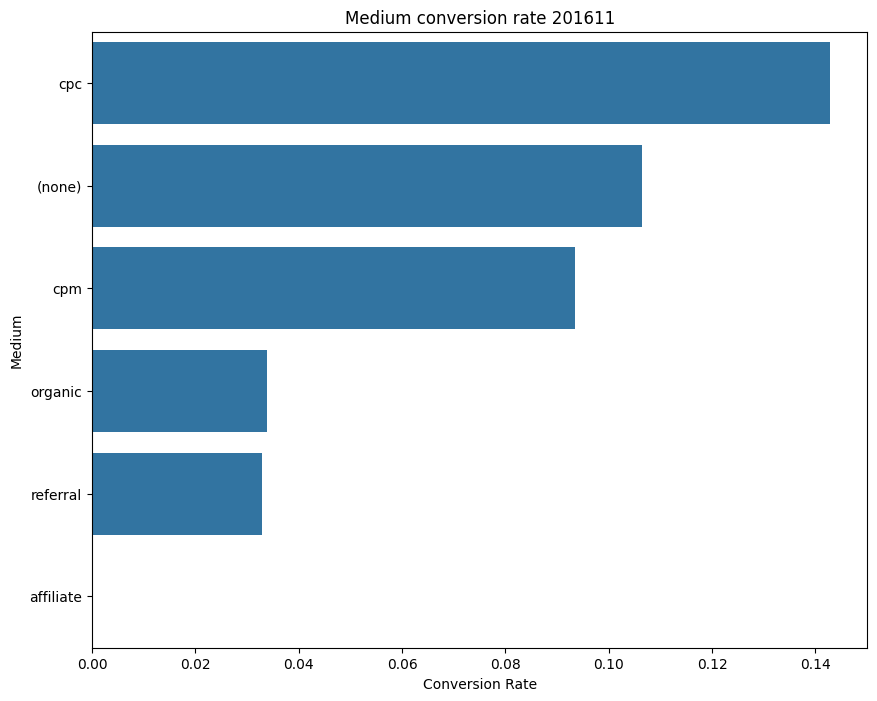

In [ ]:
funnel_df = medium_result.pivot(index='medium', columns='action', values='users').reset_index()

# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
funnel_df['conversion_rate'] = funnel_df['구매 완료'] / funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='medium', data=funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Medium conversion rate 201611')
plt.xlabel('Conversion Rate')
plt.ylabel('Medium')
plt.show()

affiliate: 제휴 마케팅 통해 유입된 트래픽

referral: 참조 트래픽. 사용자가 다른 웹사이트의 링크를 클릭해 도착한 경우. 제휴 마케팅과 비슷하나 비금전적

organic: 유기적 검색 결과

not set: 트래픽 소스 지정되지 않았거나 알 수 없는 경우

cpc(cost per click): 클릭당 비용. 유료 검색 광고를 통해 유입된 트래픽

cpm(cost per mile): 천 회 노출당 비용. 디스플레이/배너 광고 통해 유입. 광고 노출 횟수에 따라 비용 청구 = 사용자가 광고 클릭해 웹사이트에 도달한 경우

none: 직접 트래픽. 사용자가 브라우저에 url 직접 입력하거나 북마크 통해 웹사이트 도달한 경우 의미. 

In [ ]:
# 통계 검정
from scipy.stats import chi2_contingency

# '제품 목록' 대비 '구매 완료' 사용자 수를 카운트하여 테이블 생성
conversion_table = funnel_df[['medium', '제품 목록', '구매 완료']]

# 각 medium 별로 '제품 목록' 대비 '구매 완료' 비율의 차이가 통계적으로 유의미한지 검증할 준비
# 카이제곱 검정을 위한 테이블 형태로 데이터를 조정 (예: 구매 완료 vs. 구매 완료 아닌 경우)
conversion_table['not_converted'] = conversion_table['제품 목록'] - conversion_table['구매 완료']
chi2_test_data = conversion_table[['구매 완료', 'not_converted']].values

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(chi2_test_data)

chi2, p

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\238734123.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



TypeError: boolean value of NA is ambiguous

medium에 따른 구매 전환율에 차이가 있음. 그리고 pvalue가 0.05 미만이므로 각 medium이 구매 전환율에 미치는 영향이 통계적으로 유의함. 

In [ ]:
# 월별 코호트별 전환율 파악 


query = """
SELECT 
    trafficSource.medium,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    trafficSource.medium,
    action,
    YearMonth
ORDER BY 
    trafficSource.medium, users DESC

"""

monthly_medium_result = client.query(query).result().to_dataframe()


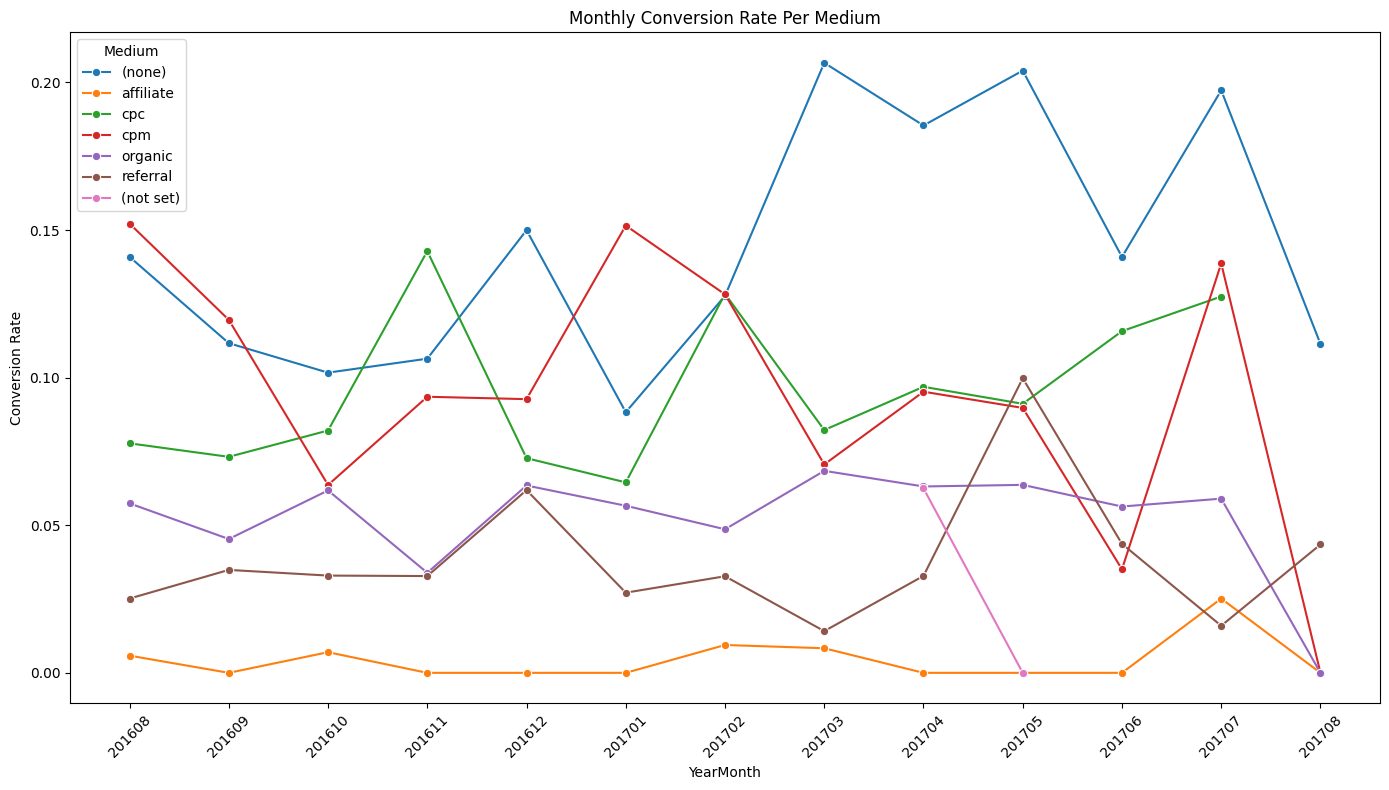

In [ ]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_medium_result.pivot_table(index=['YearMonth', 'medium'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='medium', marker='o')
plt.title('Monthly Conversion Rate Per Medium')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Medium')
plt.tight_layout()
plt.show()

확실히 직접 검색해서 전환된 사람들의 비율이 높음. 그다음이 유료 광고

그렇다면 결제 전환이 되지 않은 고객의 경우는 어떠한가?

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\2521303672.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



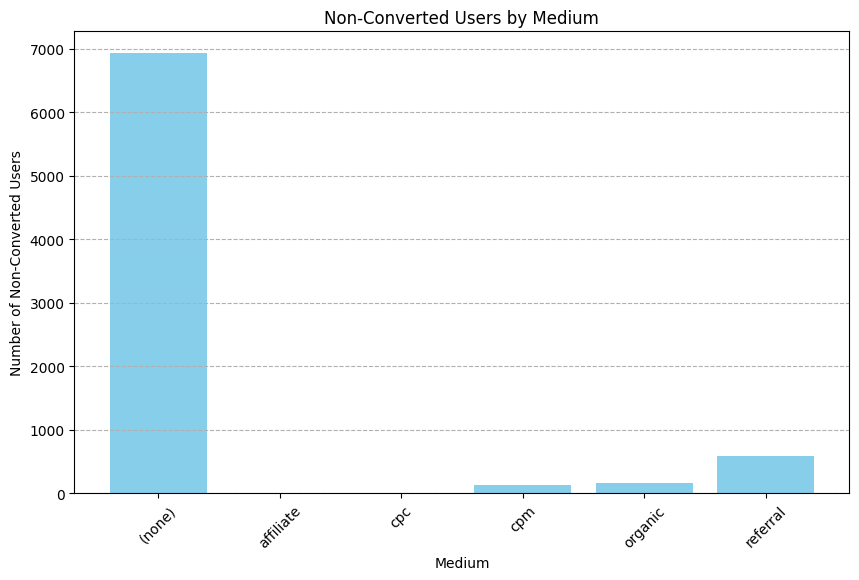

In [ ]:
# 전환 안 된 고객들의 유입 매체 확인

conversion_table.fillna(0, inplace = True)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(conversion_table['medium'], conversion_table['not_converted'], color='skyblue')
plt.title('Non-Converted Users by Medium')
plt.xlabel('Medium')
plt.ylabel('Number of Non-Converted Users')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

#### 2) 캠페인별 코호트 

In [ ]:
# 월별 코호트별 전환율 파악 


query = """
SELECT 
    trafficSource.campaign AS Campaign,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    Campaign,
    action,
    YearMonth
ORDER BY 
    Campaign, users DESC

"""

monthly_cam_result = client.query(query).result().to_dataframe()


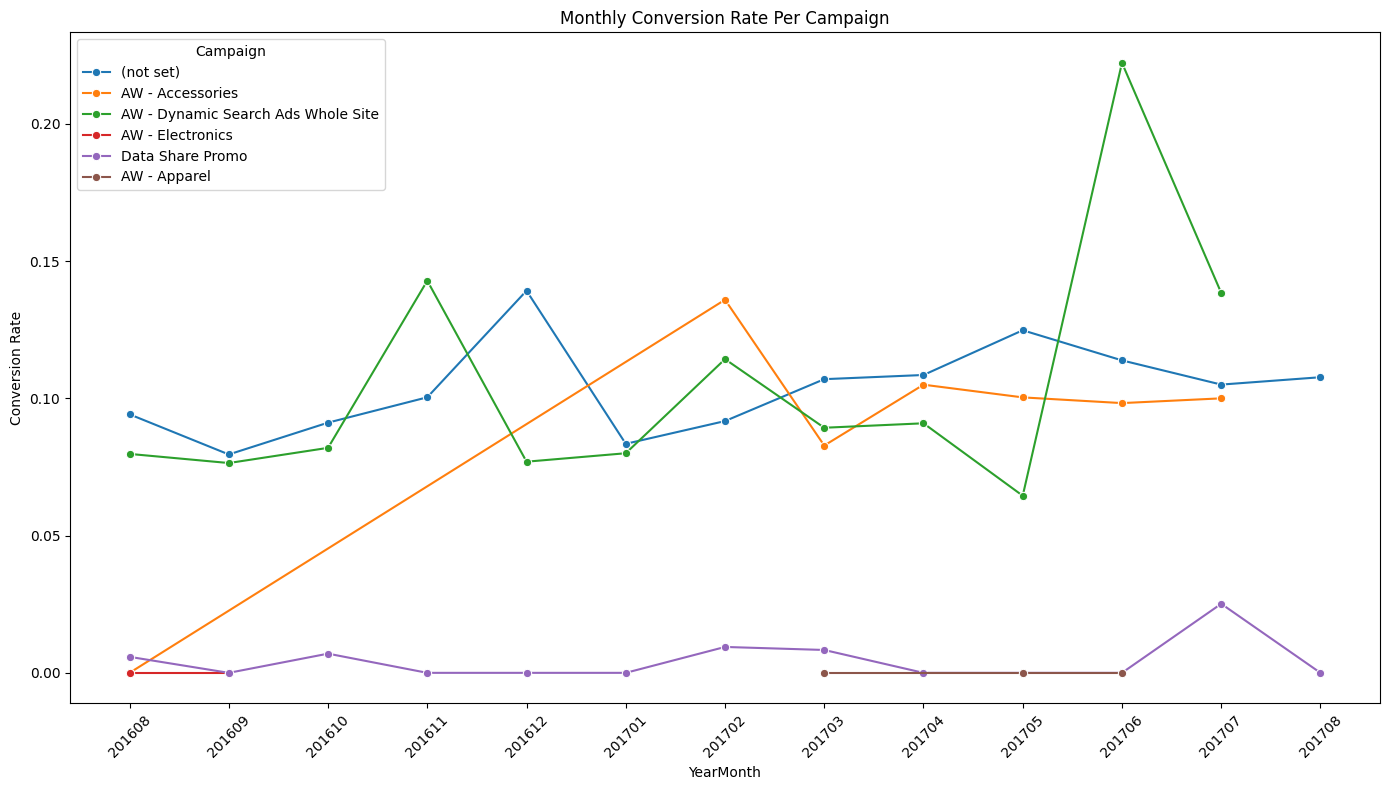

In [ ]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_cam_result.pivot_table(index=['YearMonth', 'Campaign'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='Campaign', marker='o')
plt.title('Monthly Conversion Rate Per Campaign')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Campaign')
plt.tight_layout()
plt.show()

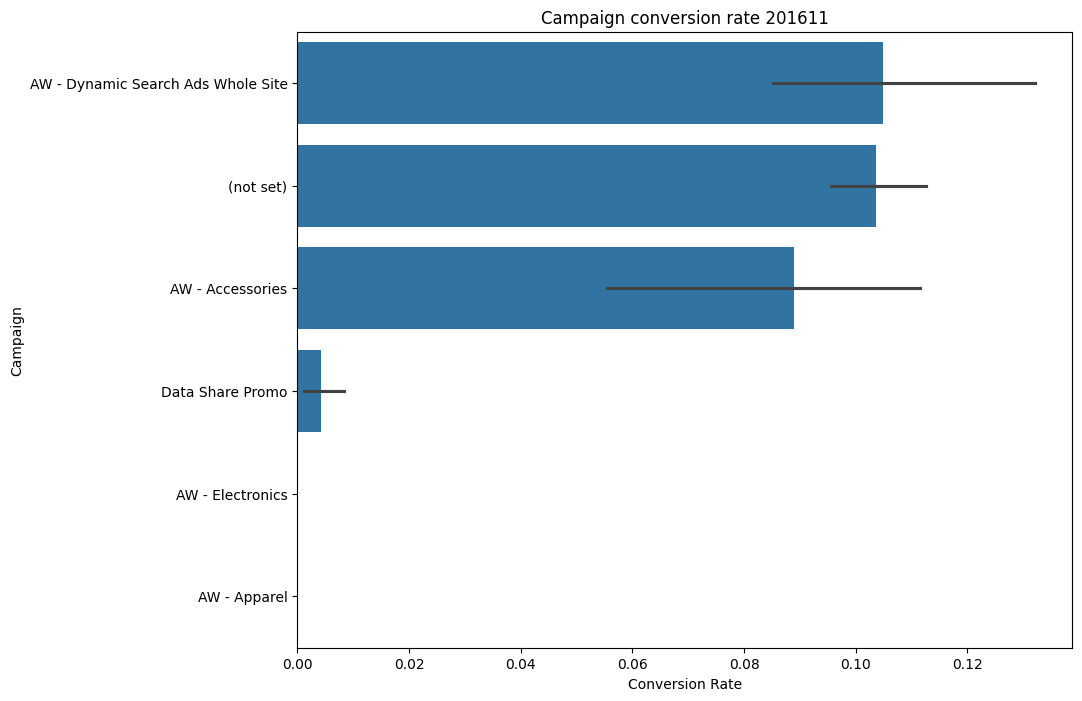

In [ ]:

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='Campaign', data=pivot_df.sort_values('conversion_rate', ascending=False))
plt.title('Campaign conversion rate 201611')
plt.xlabel('Conversion Rate')
plt.ylabel('Campaign')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\1562912570.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



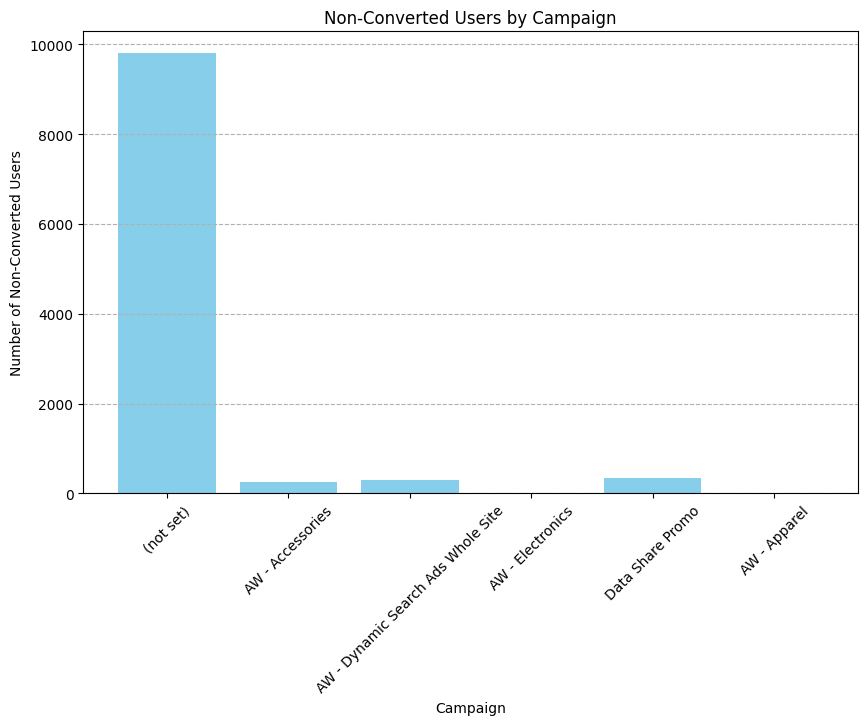

In [ ]:
# 전환 안 된 고객들의 유입 매체 확인
# 전환되지 않은 사용자
# '제품 목록' 대비 '구매 완료' 사용자 수를 카운트하여 테이블 생성
conversion_table_cam = pivot_df[['Campaign', '제품 목록', '구매 완료']]
conversion_table_cam['not_converted'] = conversion_table_cam['제품 목록'] - conversion_table_cam['구매 완료']
conversion_table_cam.fillna(0, inplace = True)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(conversion_table_cam['Campaign'], conversion_table_cam['not_converted'], color='skyblue')
plt.title('Non-Converted Users by Campaign')
plt.xlabel('Campaign')
plt.ylabel('Number of Non-Converted Users')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

#### 3) 소스별 코호트 

In [ ]:

# 월별 코호트별 전환율 파악 


query = """
SELECT 
    trafficSource.source AS Source,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    Source,
    action,
    YearMonth
ORDER BY 
    Source, users DESC

"""

monthly_sor_result = client.query(query).result().to_dataframe()


C:\Users\USER\AppData\Local\Temp\ipykernel_21608\646977477.py:15: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



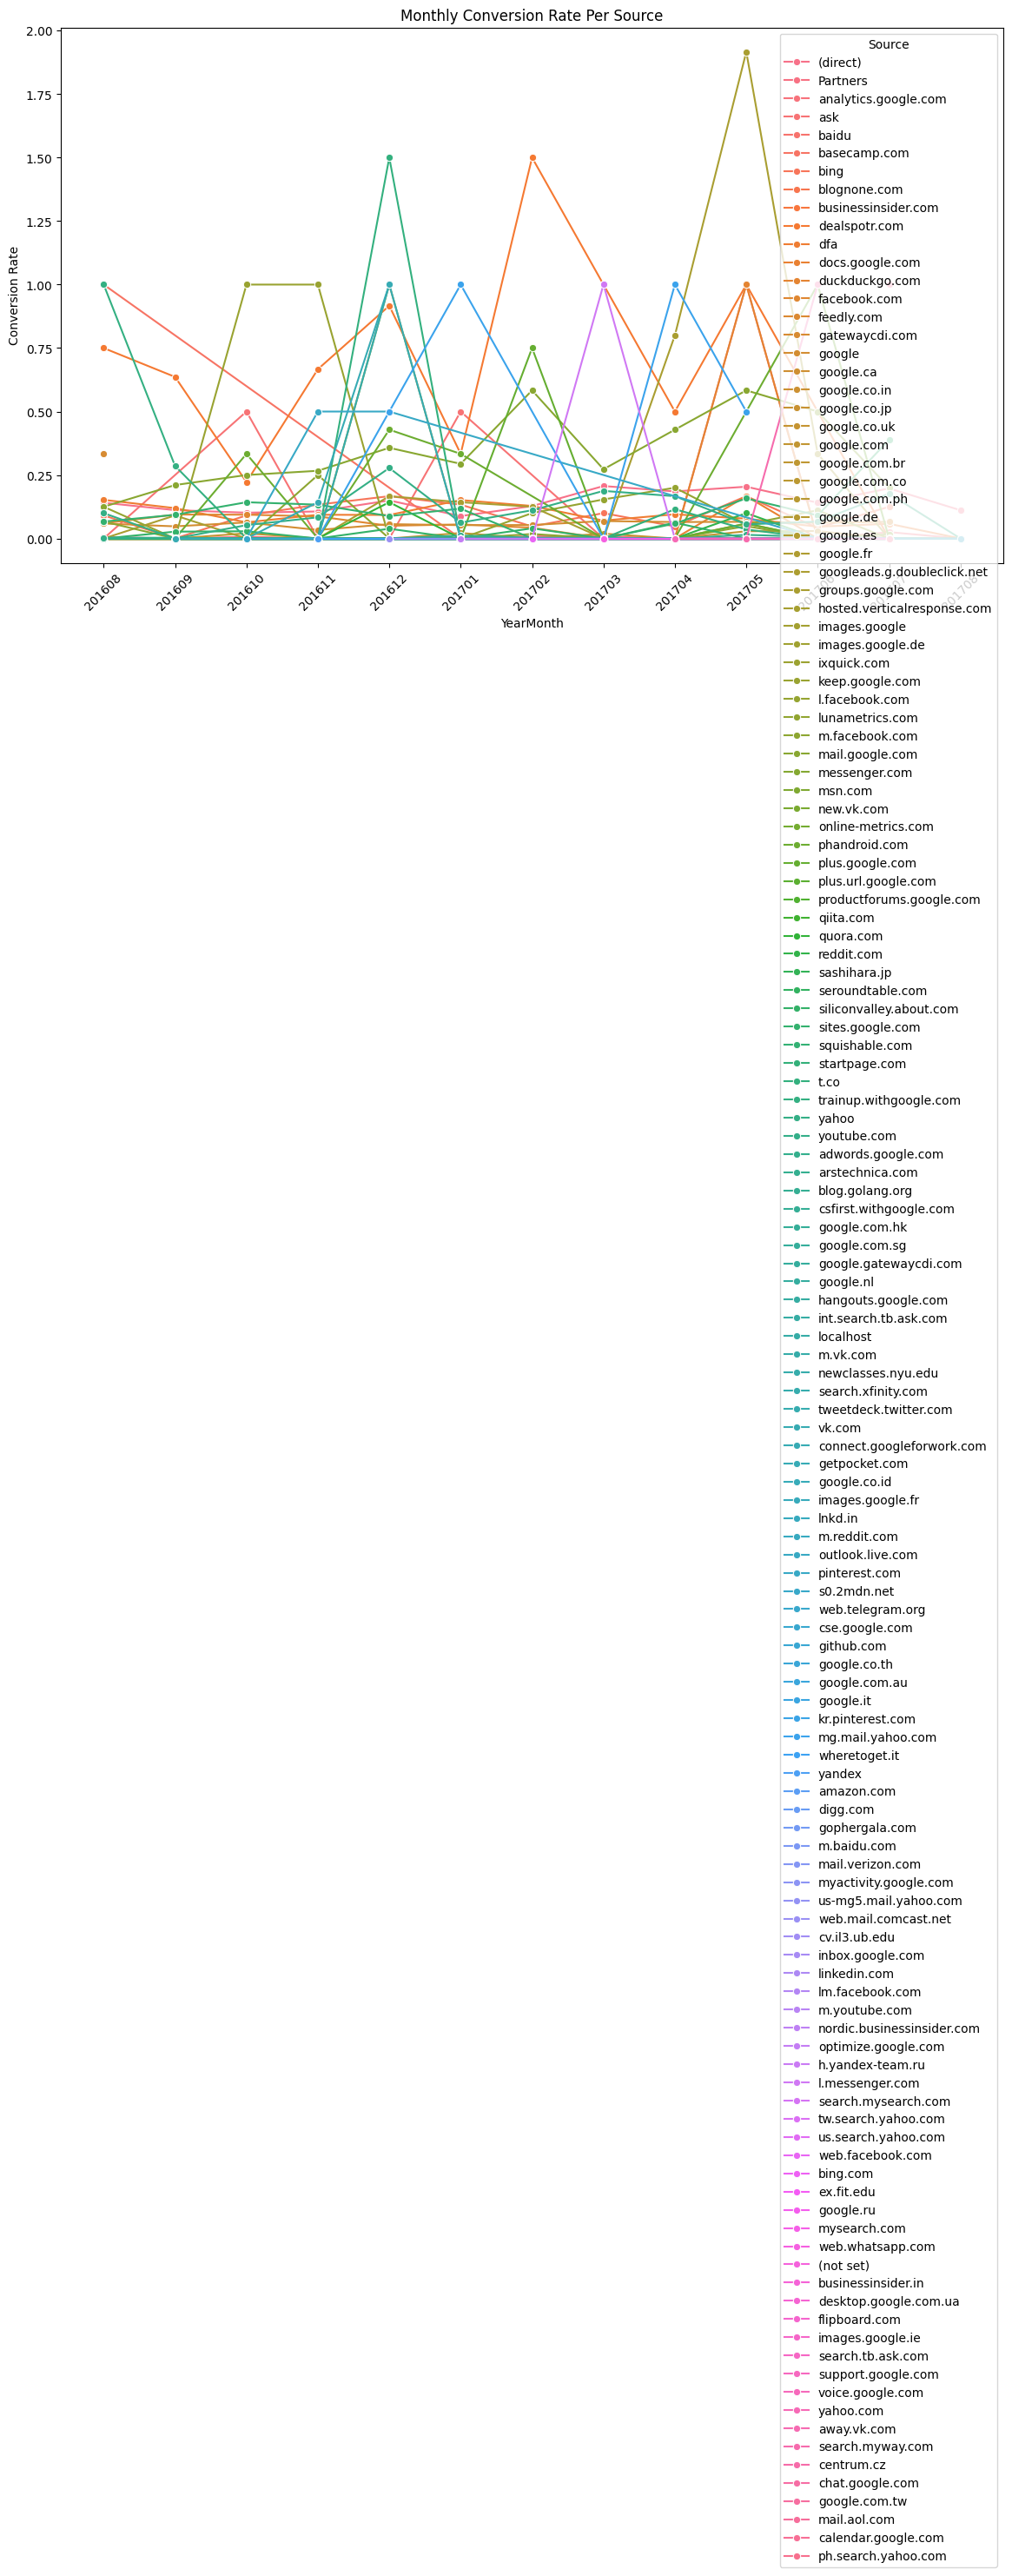

In [ ]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_sor_result.pivot_table(index=['YearMonth', 'Source'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='Source', marker='o')
plt.title('Monthly Conversion Rate Per Source')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.tight_layout()
plt.show()

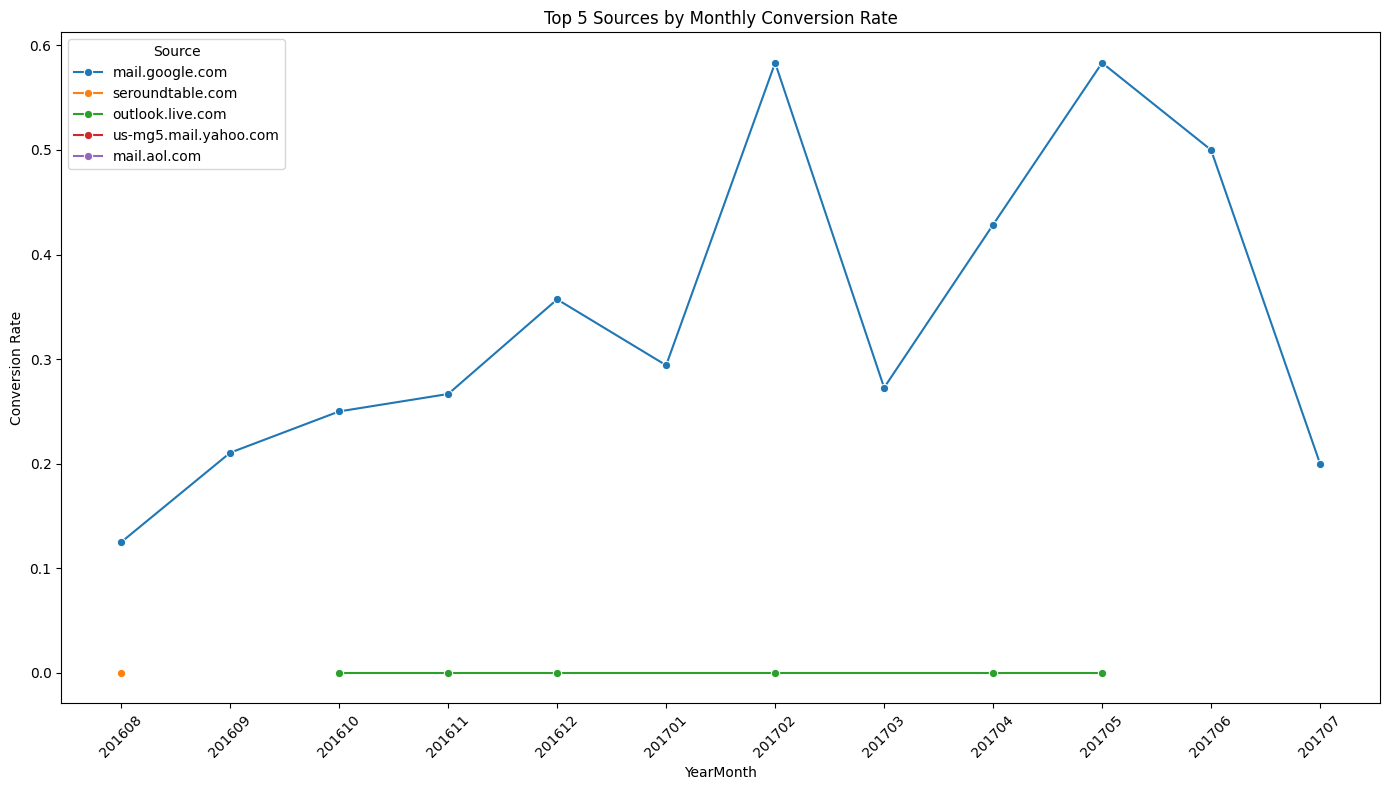

In [ ]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_sor_result.pivot_table(
    index=['YearMonth', 'Source'], 
    columns='action', 
    values='users', 
    aggfunc='mean', 
    fill_value=0
).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 각 소스별로 가장 높은 전환율을 가진 월을 찾아서 상위 5개 소스를 결정
top_sources = pivot_df.groupby('Source')['ConversionRate'].max().sort_values(ascending=False).head(5).index

# 상위 5개 소스만 필터링
top_pivot_df = pivot_df[pivot_df['Source'].isin(top_sources)]

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=top_pivot_df, x='YearMonth', y='ConversionRate', hue='Source', marker='o')
plt.title('Top 5 Sources by Monthly Conversion Rate')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\445095980.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\445095980.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



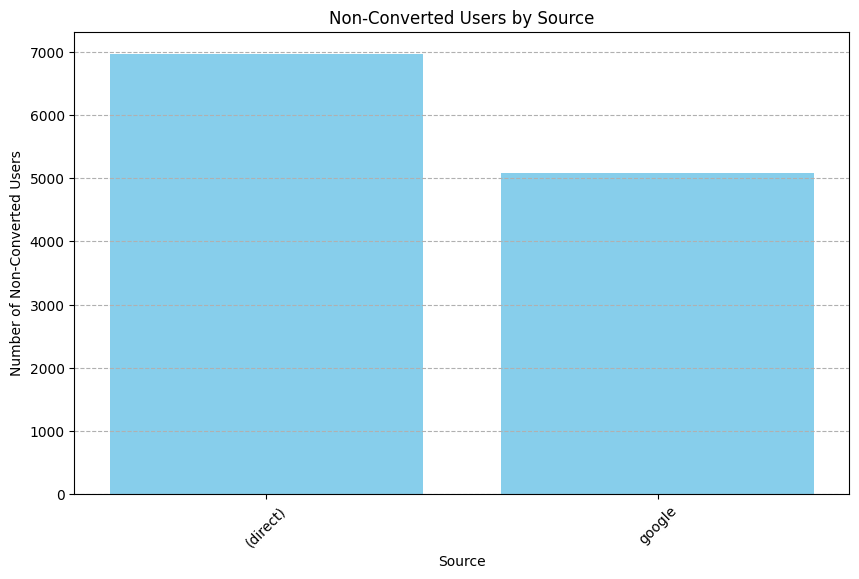

In [ ]:
# 미전환 유저

# 전환 안 된 고객들의 유입 매체 확인
# 전환되지 않은 사용자
# '제품 목록' 대비 '구매 완료' 사용자 수를 카운트하여 테이블 생성
conversion_table_sor = pivot_df[['Source', '제품 목록', '구매 완료']]
conversion_table_sor['not_converted'] = conversion_table_sor['제품 목록'] - conversion_table_sor['구매 완료']
conversion_table_sor.fillna(0, inplace = True)

# 전환되지 않은 사용자 수가 많은 상위 5개 유입 매체 추출
top_5_sources = conversion_table_sor.sort_values('not_converted', ascending=False).head(5)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(top_5_sources['Source'], top_5_sources['not_converted'], color='skyblue')
plt.title('Non-Converted Users by Source')
plt.xlabel('Source')
plt.ylabel('Number of Non-Converted Users')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

#### 4) 광고별 코호트 

In [ ]:

# 월별 코호트별 전환율 파악 


query = """
SELECT 
    trafficSource.adContent AS AdContent,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    AdContent,
    action,
    YearMonth
ORDER BY 
    AdContent, users DESC

"""

monthly_ad_result = client.query(query).result().to_dataframe()


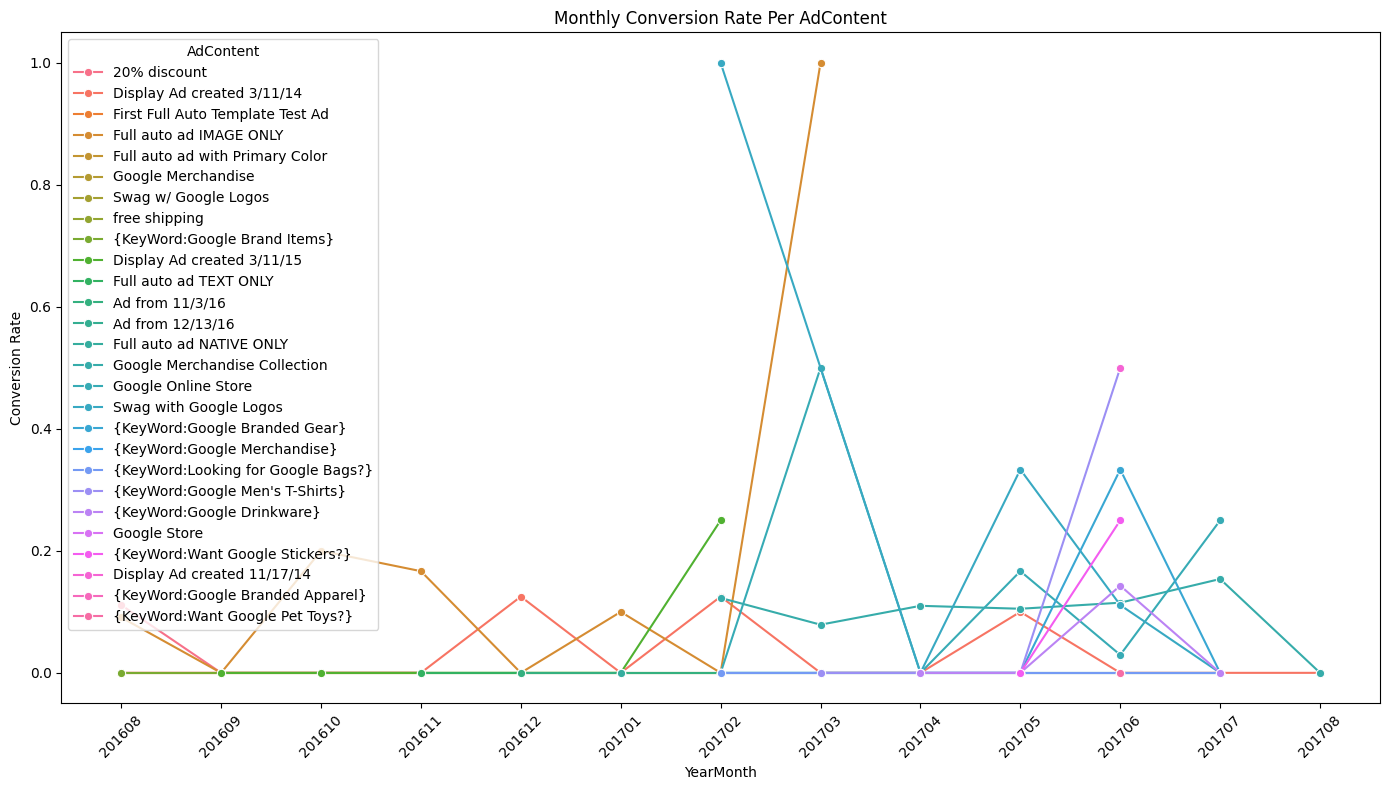

In [ ]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_ad_result.pivot_table(index=['YearMonth', 'AdContent'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='AdContent', marker='o')
plt.title('Monthly Conversion Rate Per AdContent')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='AdContent')
plt.tight_layout()
plt.show()

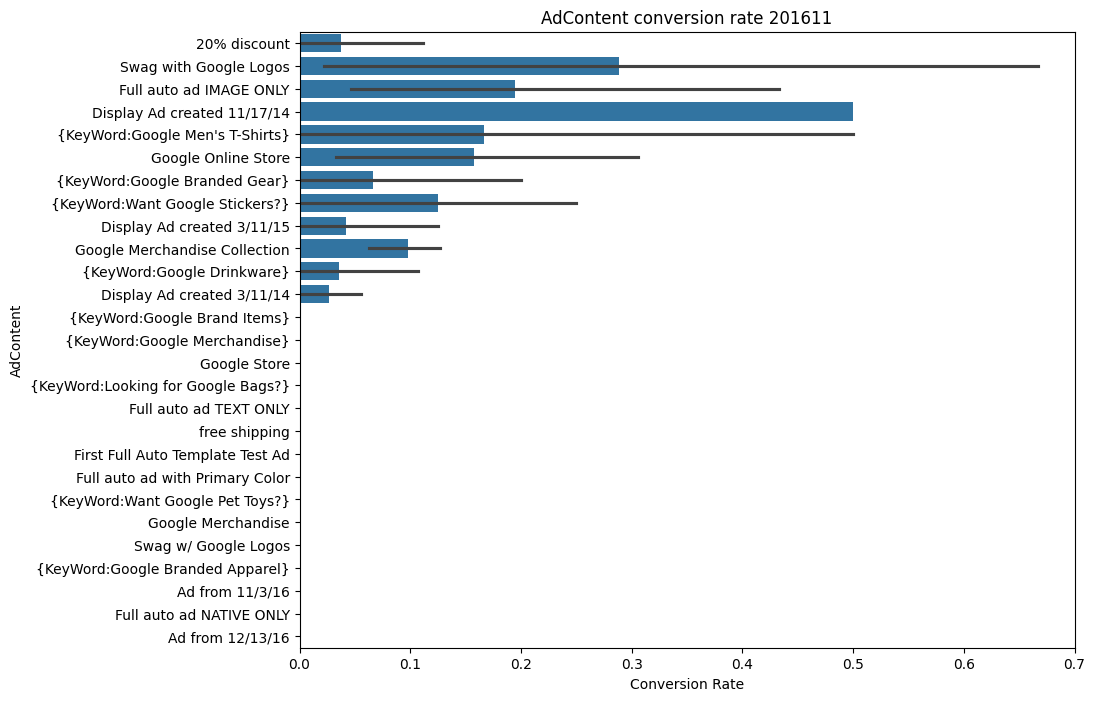

In [ ]:
# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
pivot_df['conversion_rate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='AdContent', data=pivot_df.sort_values('conversion_rate', ascending=False))
plt.title('AdContent conversion rate 201611')
plt.xlabel('Conversion Rate')
plt.ylabel('AdContent')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\2183549771.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\2183549771.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



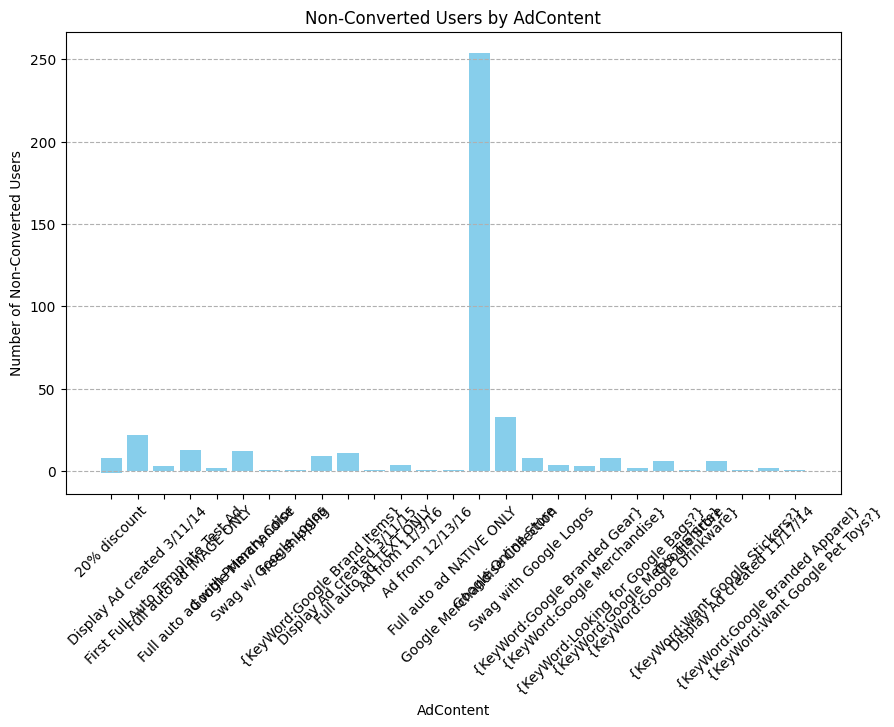

In [ ]:
# 미전환 고객 
conversion_table_ad = pivot_df[['AdContent', '제품 목록', '구매 완료']]
conversion_table_ad['not_converted'] = conversion_table_ad['제품 목록'] - conversion_table_ad['구매 완료']
conversion_table_ad.fillna(0, inplace = True)


# 시각화
plt.figure(figsize=(10, 6))
plt.bar(conversion_table_ad['AdContent'], conversion_table_ad['not_converted'], color='skyblue')
plt.title('Non-Converted Users by AdContent')
plt.xlabel('AdContent')
plt.ylabel('Number of Non-Converted Users')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()

#### 5) 소셜 미디어 플랫폼별 코호트에 따른 전환율

In [ ]:
# 소셜 미디어에서 세션으로 넘어온 유저들의 수와 비율
query = """
WITH ReferralStats AS (
  SELECT
    (SELECT COUNT(DISTINCT fullVisitorId) 
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, 
     UNNEST(hits) AS hits 
     WHERE hits.social.hasSocialSourceReferral = 'Yes') AS socialReferralUsers,
    COUNT(DISTINCT fullVisitorId) AS totalUsers
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
)

SELECT
  socialReferralUsers,
  totalUsers,
  (socialReferralUsers * 100.0 / totalUsers) AS percentageOfSocialReferralUsers
FROM ReferralStats

"""
media_result = client.query(query).result().to_dataframe()

In [ ]:
# hits.social.socialNetwork: 소셜 네크워크 이름. 트래픽 소스의 추천 소셜 네트워크와 관련
# 트래픽 소스의 추천 소셜 네트워크: 유저가 어떤 소셜 네트워크를 통해 웹사이트에 연결됐는지 나타내는 정보 
query = """
SELECT 
    hit.social.socialNetwork
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`, 
    UNNEST(hits) AS hit
WHERE 
    hit.social.socialNetwork IS NOT NULL
GROUP BY 
    hit.social.socialNetwork

"""

media_conv = client.query(query).result().to_dataframe()

media_conv

,socialNetwork
0,Tumblr
1,reddit
2,Pinterest
3,YouTube
4,Twitter
5,Hacker News
6,Pocket
7,Digg
8,Google Groups
9,(not set)


In [ ]:
# 유입 소셜 네트워크별 전환율 비교: 전체 기간 

query = """
SELECT 
    hits.social.socialNetwork,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6') AND hits.social.socialNetwork IS NOT NULL
GROUP BY 
    hits.social.socialNetwork,
    action
ORDER BY 
    hits.social.socialNetwork, users DESC

"""

media_conv = client.query(query).result().to_dataframe()


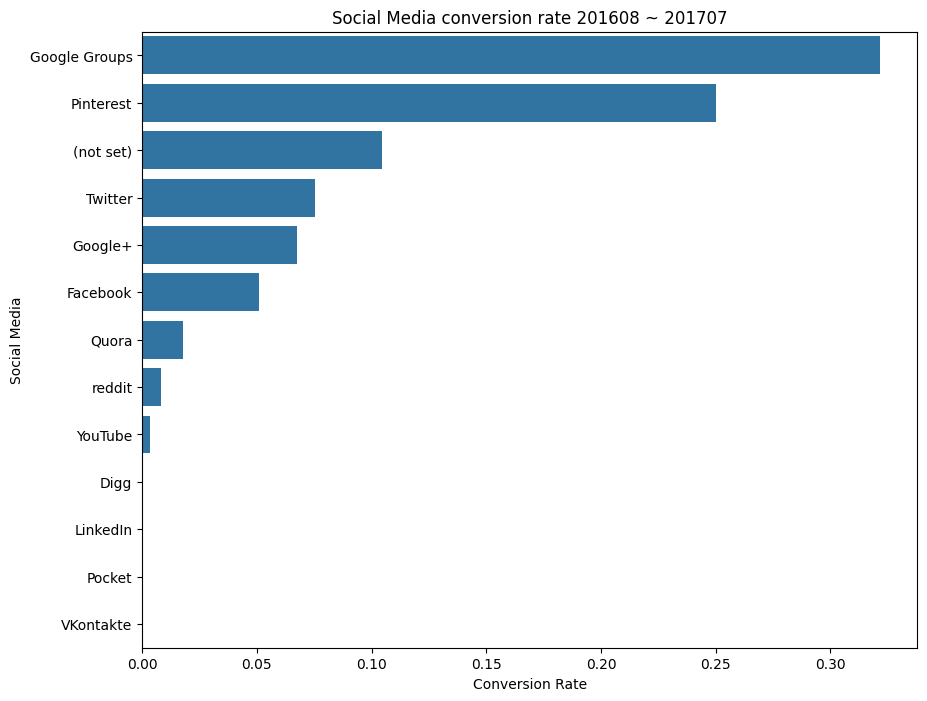

In [ ]:
funnel_df = media_conv.pivot(index='socialNetwork', columns='action', values='users').reset_index()

# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
funnel_df['conversion_rate'] = funnel_df['구매 완료'] / funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='socialNetwork', data=funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Social Media conversion rate 201608 ~ 201707')
plt.xlabel('Conversion Rate')
plt.ylabel('Social Media')
plt.show()

In [ ]:
# '제품 목록' 대비 '구매 완료' 사용자 수를 카운트하여 테이블 생성
conversion_table = funnel_df[['socialNetwork', '제품 목록', '구매 완료']]
conversion_table.fillna(0, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_26856\3127521398.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
conversion_table # 근데 확인 결과 거의 대부분이 미식별 유저이긴 함.. 

action,socialNetwork,제품 목록,구매 완료
0,(not set),95075,9923
1,Digg,1,0
2,Facebook,705,36
3,Google Groups,115,37
4,Google+,74,5
5,LinkedIn,4,0
6,Pinterest,8,2
7,Pocket,2,0
8,Quora,56,1
9,Twitter,93,7


In [ ]:
# 각 medium 별로 '제품 목록' 대비 '구매 완료' 비율의 차이가 통계적으로 유의미한지 검증할 준비
conversion_table['not_converted'] = conversion_table['제품 목록'] - conversion_table['구매 완료']
chi2_test_data = conversion_table[['구매 완료', 'not_converted']].values

# 검정 수행
chi2, p, dof, expected = chi2_contingency(chi2_test_data)

chi2, p

C:\Users\USER\AppData\Local\Temp\ipykernel_26856\2864148411.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(475.1493384166535, 4.2820276697568543e-94)

In [ ]:
# 유입 소셜 네트워크별 전환율 비교: 201611

query = """
SELECT 
    hits.social.socialNetwork,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_201611*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6') AND hits.social.socialNetwork IS NOT NULL
GROUP BY 
    hits.social.socialNetwork,
    action
ORDER BY 
    hits.social.socialNetwork, users DESC

"""

media_conv = client.query(query).result().to_dataframe()


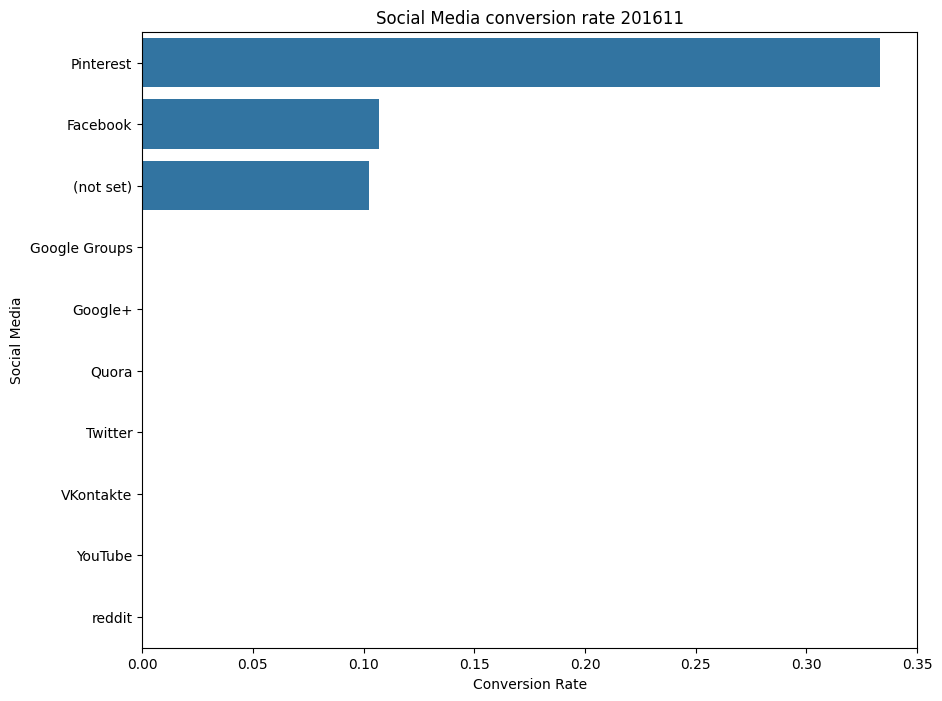

In [ ]:
funnel_df = media_conv.pivot(index='socialNetwork', columns='action', values='users').reset_index()

# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
funnel_df['conversion_rate'] = funnel_df['구매 완료'] / funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='socialNetwork', data=funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Social Media conversion rate 201611')
plt.xlabel('Conversion Rate')
plt.ylabel('Social Media')
plt.show()

In [ ]:
# 월별 코호트별 전환율 파악 

query = """
SELECT 
    hits.social.socialNetwork,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    hits.social.socialNetwork,
    action,
    YearMonth
ORDER BY 
    users DESC

"""

monthly_media_result = client.query(query).result().to_dataframe()


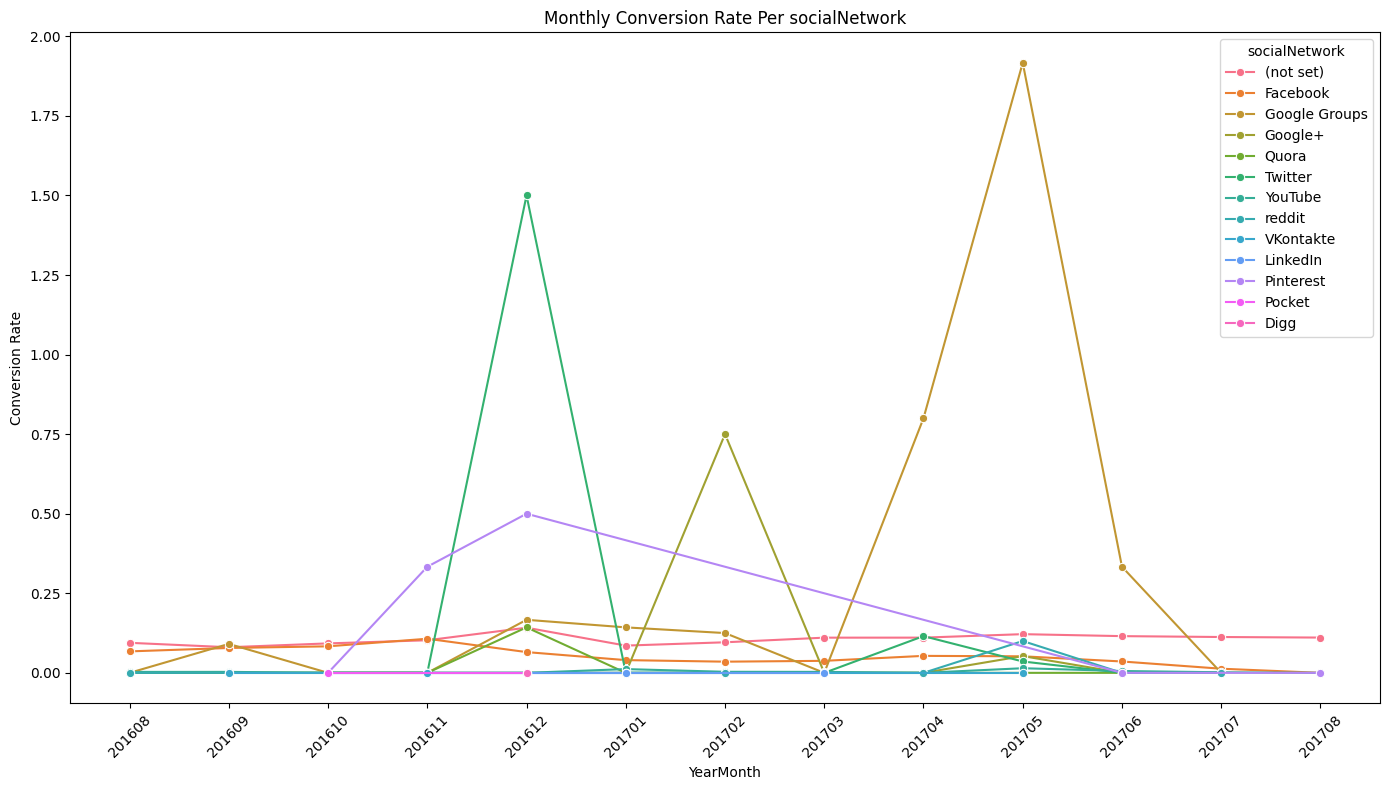

In [ ]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_media_result.pivot_table(index=['YearMonth', 'socialNetwork'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='socialNetwork', marker='o')
plt.title('Monthly Conversion Rate Per socialNetwork')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='socialNetwork')
plt.tight_layout()
plt.show()

#### 6) 요일별 전환율 비교

In [ ]:
# 요일별 코호트에 따른 전환율 

query = """
SELECT 
    EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', Date)) AS DayOfWeek,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    DayOfWeek,
    action
ORDER BY 
    DayOfWeek, users DESC
"""



day_conv = client.query(query).result().to_dataframe()


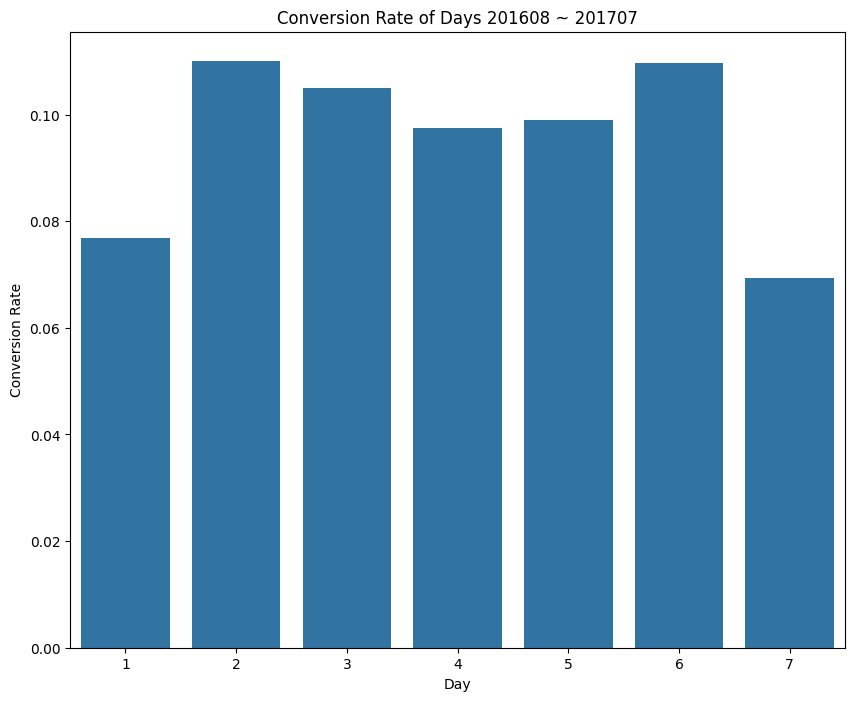

In [ ]:
day_funnel_df = day_conv.pivot(index='DayOfWeek', columns='action', values='users').reset_index()

# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
day_funnel_df['conversion_rate'] = day_funnel_df['구매 완료'] / day_funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='DayOfWeek', y='conversion_rate', data=day_funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Conversion Rate of Days 201608 ~ 201707')
plt.xlabel('Day')
plt.ylabel('Conversion Rate')
plt.show()

In [ ]:
# 위에선 크게 알 수 있는 게 없으니 전체 기간 별로 어떤지 확인해보자 
query = """
SELECT 
    EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', date)) AS DayOfWeek,
    FORMAT_DATE("%Y%m", PARSE_DATE('%Y%m%d', date)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS Action,
    COUNT(DISTINCT fullVisitorID) AS Users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    DayOfWeek, YearMonth, Action
ORDER BY 
    YearMonth, DayOfWeek, Action

"""

weekly_conv = client.query(query).result().to_dataframe()


In [ ]:
filtered_df = weekly_conv[weekly_conv['Action'].isin(['제품 목록', '구매 완료'])]

# 전환율 계산을 위해 pivot_table 생성
pivot_df = filtered_df.pivot_table(index=['YearMonth', 'DayOfWeek'], columns='Action', values='Users', aggfunc='sum').reset_index()

# '구매 완료' 사용자 수를 '제품 목록' 사용자 수로 나누어 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

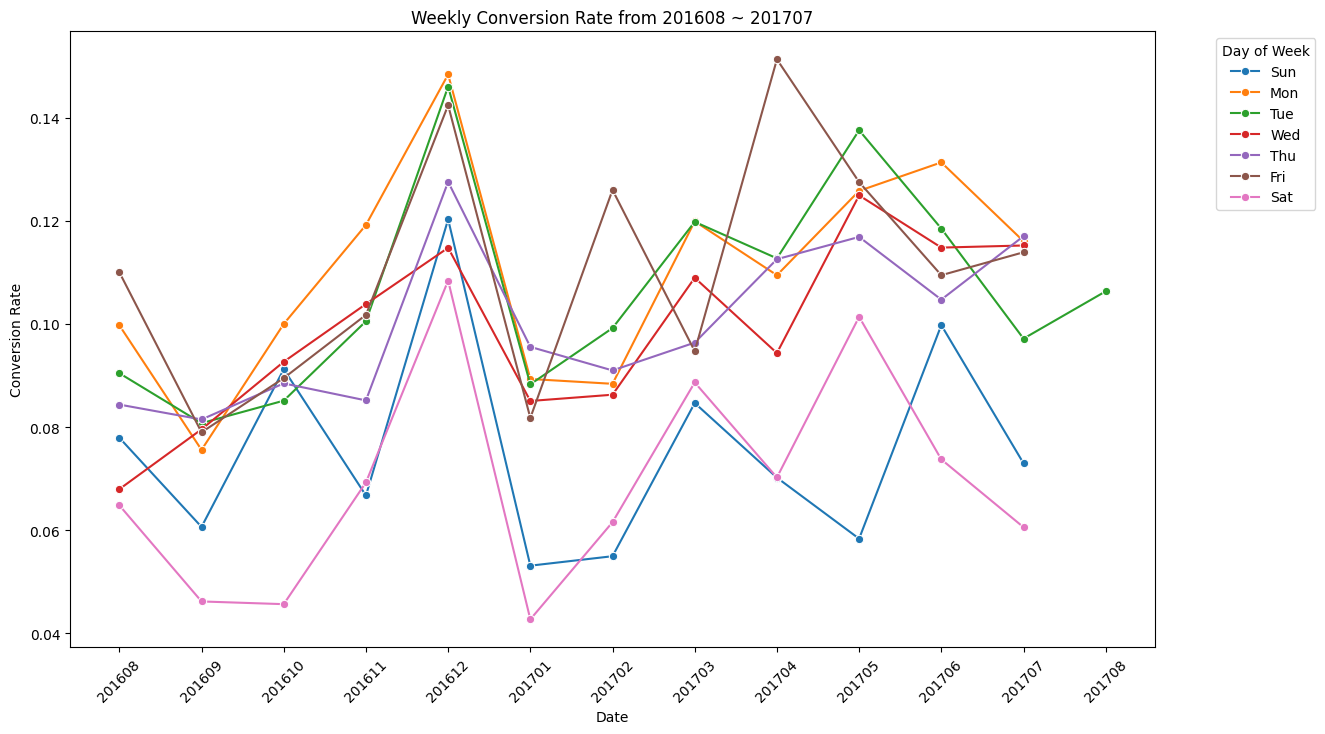

In [ ]:
day_names = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
pivot_df['DayOfWeekName'] = pivot_df['DayOfWeek'].map(day_names)

# 시각화에 DayOfWeekName을 사용
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='DayOfWeekName', marker='o', palette='tab10')
plt.title('Weekly Conversion Rate from 201608 ~ 201707')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

* 평일, 특히 월요일은 전환률이 전반적으로 높은 것 같고 주말은 전반적으로 전환률 낮음 이거 외에는 또 뭐를 알 수가 있지... 



* 보면 제품 목록 -> 제품 상세 목록은 다들 잘 넘어감 근데 제품 상세 목록 -> 결제에서 0.3 정도만 들어오고 결제 -> 구매 완료까지 또 0.3 정도만 남음 

* mau를 보면 1611에서 최고점 찍고 1611 - 1612 구간에서 폭락함.
-> nau 보니 신규 유저는 1611에 최고치. 그러다 1612에는 평소 신규 유저 수 정도로 돌아옴. 
-> mau는 신규 유저가 유입이 그때 많이 돼서 최고점이었던듯 

전환률은 1612가 최고지점.
신규 유저 수는 전달에 비해 줄었지만(평소대로 돌아왔으나) 유저들의 전환률은 올라갔다? 왜 올라갔지 기존 유저들의 구매 전환율이 확 튀었나? 

우선 신규 유저들의 전환률을 확인해보자. 


#### 7) 유저 코호트별 전환률 



* 기존 유저

* 신규 유저 

In [ ]:
# 신규 유저들의 전환률

query = """
SELECT 
    FORMAT_DATE("%Y%m", PARSE_DATE('%Y%m%d', date)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS Action,
    COUNT(DISTINCT fullVisitorID) AS NewUsers
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE 
    totals.newVisits = 1 AND
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    YearMonth, Action
ORDER BY 
    YearMonth, Action

"""

new_user_conv_rate = client.query(query).result().to_dataframe()

In [ ]:
filtered_df = new_user_conv_rate[new_user_conv_rate['Action'].isin(['제품 목록', '구매 완료'])]

# 전환율 계산을 위해 pivot_table 생성
pivot_df = filtered_df.pivot_table(index=['YearMonth'], columns='Action', values='NewUsers', aggfunc='sum').reset_index()

# '구매 완료' 사용자 수를 '제품 목록' 사용자 수로 나누어 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

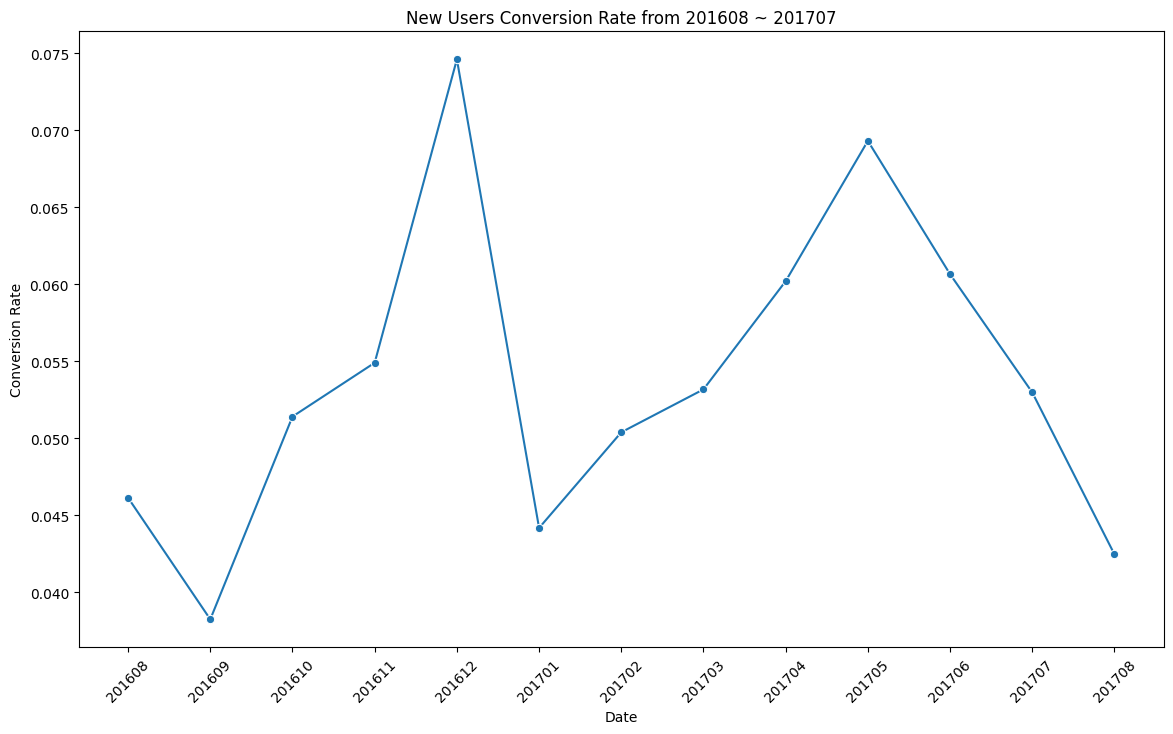

In [ ]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', marker='o')
plt.title('New Users Conversion Rate from 201608 ~ 201707')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 기존 유저들의 전환률 

query = """
SELECT 
    FORMAT_DATE("%Y%m", PARSE_DATE('%Y%m%d', date)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS Action,
    COUNT(DISTINCT fullVisitorID) AS OldUsers
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE 
    totals.newVisits IS NULL AND
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    YearMonth, Action
ORDER BY 
    YearMonth, Action

"""
old_user_conv_rate = client.query(query).result().to_dataframe()

In [ ]:
filtered_df = old_user_conv_rate[old_user_conv_rate['Action'].isin(['제품 목록', '구매 완료'])]

# 전환율 계산을 위해 pivot_table 생성
pivot_df = filtered_df.pivot_table(index=['YearMonth'], columns='Action', values='OldUsers', aggfunc='sum').reset_index()

# '구매 완료' 사용자 수를 '제품 목록' 사용자 수로 나누어 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

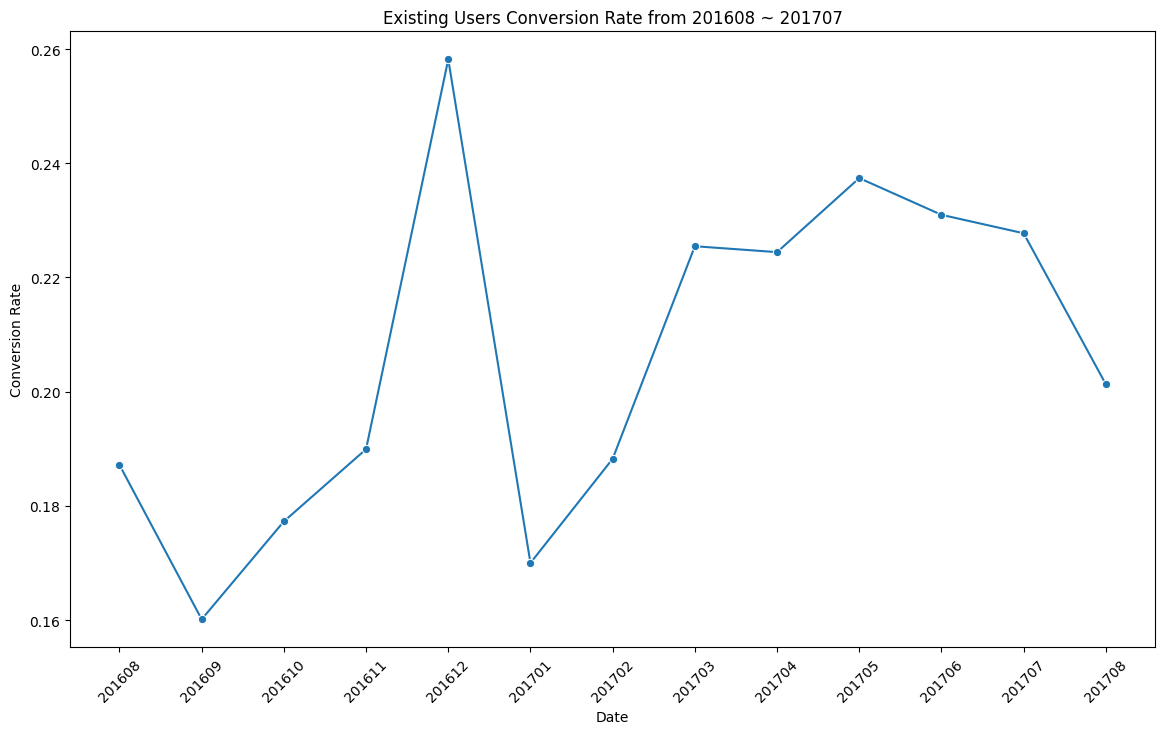

In [ ]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', marker='o')
plt.title('Existing Users Conversion Rate from 201608 ~ 201707')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.show()

확인해 보니 기존 유저 / 신규 유저 코호트 모두 1612에 가장 높은 전환률을 가지지만

일단 기존 유저들의 전환률이 평균적으로 신규 유저들 보다 4배 이상 높음

아무튼 신규/기존과는 증가한 전환률이 관련 없는듯 

- 프로모션이나 이런 거 확인해보자 

- 그리고 신규 유저 전환률은 왜 이렇게 낮은 거지? exiting screen 확인해보자 



In [ ]:
# 신규 유저들이 어디서 이탈하는지 확인해보자 

# hits.appInfo.landingScreenName: 세션의 방문 화면
# 아니 근데 이건 앱 정보 아닌가?
query = """
WITH first_visits AS (
  SELECT
    fullVisitorId,
    (SELECT hits.appInfo.exitScreenName FROM UNNEST(hits) hits WHERE hits.type='PAGE' AND hits.isEntrance IS TRUE LIMIT 1) AS exitingScreenName
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    totals.newVisits = 1
)

SELECT
  exitingScreenName,
  COUNT(fullVisitorId) AS new_users
FROM
  first_visits
GROUP BY
  exitingScreenName
ORDER BY
  new_users DESC
"""

new_exit_result = client.query(query).result().to_dataframe()




C:\Users\USER\AppData\Local\Temp\ipykernel_26856\2992256695.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




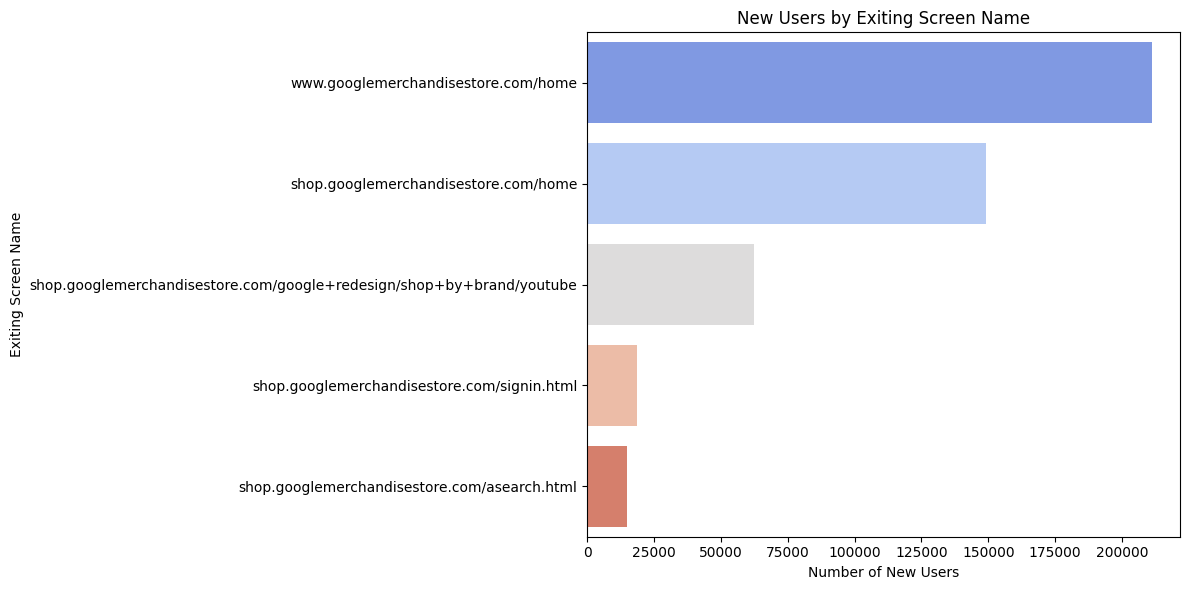

In [ ]:
top5_exiting_pages = new_exit_result.sort_values('new_users', ascending=False).head(5)

# 막대 그래프 생성
plt.figure(figsize=(12, 6))  # 그래프 크기 조정
sns.barplot(x='new_users', y='exitingScreenName', data=top5_exiting_pages, palette='coolwarm')  # y축에 exitingScreenName을 사용하여 가로 막대 그래프 생성

# 그래프 제목과 축 라벨 추가
plt.title('New Users by Exiting Screen Name')
plt.xlabel('Number of New Users')
plt.ylabel('Exiting Screen Name')

# 그래프 표시
plt.tight_layout()
plt.show()

#### 8) 기기 코호트별 전환율 

In [ ]:
# 사용 기기별 전환율 
query = """
SELECT 
    device.deviceCategory AS Device,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    Device,
    action
ORDER BY 
    Device, users DESC
"""

device_conv = client.query(query).result().to_dataframe()

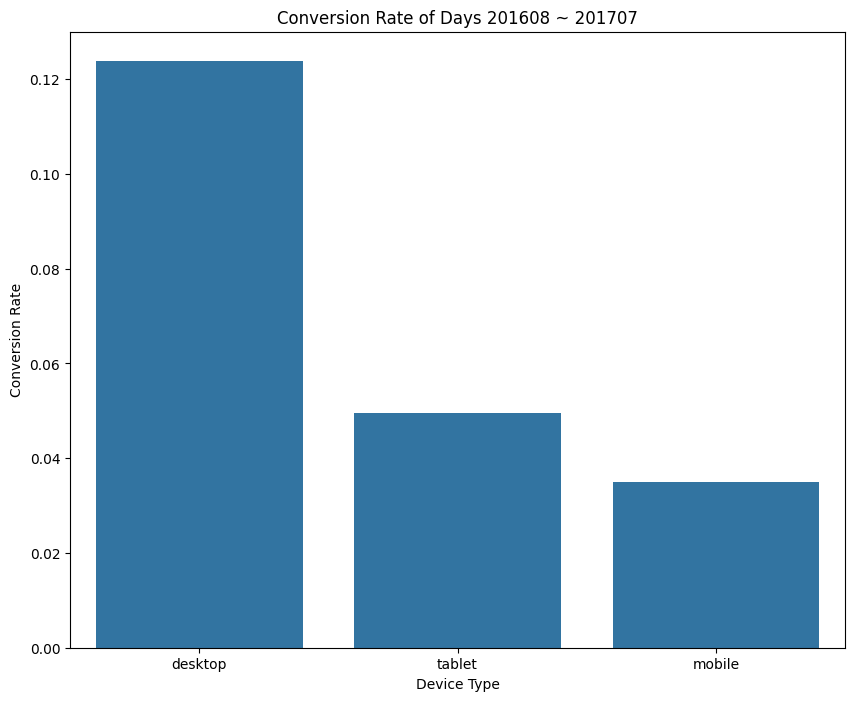

In [ ]:
# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
device_funnel_df = device_conv.pivot(index='Device', columns='action', values='users').reset_index()
device_funnel_df['conversion_rate'] = device_funnel_df['구매 완료'] / device_funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Device', y='conversion_rate', data=device_funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Conversion Rate of Days 201608 ~ 201707')
plt.xlabel('Device Type')
plt.ylabel('Conversion Rate')
plt.show()

In [ ]:
device_funnel_df


action,Device,결제,구매 완료,제품 목록,제품 세부 정보 보기,conversion_rate
0,desktop,15488,9049,73076,72927,0.12383
1,mobile,2450,812,23199,23102,0.035002
2,tablet,341,160,3227,3227,0.049582


- desktop으로 유입되는 수가 tablet으로 유입되는 수의 3배이긴 하지만, tablet과 mobile은 desktop에 비해 전환률이 현저히 떨어짐 -> ui/ux 때문일까?

- 그리고 결제 -> 구매 완료로 넘어가는 수가 너무 적음. 결제 ui/ux가 불편한가?

In [ ]:
# 통계 검정
# 귀무 가설: 모든 device에 대한 변환율은 같다.
# 대립 가설: 적어도 하나의 device에서의 변환율은 다르다. 
# 카이제곱 검정 사용: 왜냐? 수치형 데이터지만 위 빈도수를 각 범주 내의 발생 빈도로 해석
data = [
    [73076, 9049],  # desktop
    [23199, 812],    # mobile
    [3227, 160]      # tablet
]

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(data)

chi2, p, dof, expected

(1385.8588044136682,
 1.1603373529814404e-301,
 2,
 array([[74610.82831917,  7514.17168083],
        [21814.07121792,  2196.92878208],
        [ 3077.10046292,   309.89953708]]))

pvalue < 0.05이므로 귀무 가설을 기각함. 

In [ ]:
# 원래 이렇게 전환율이 낮았는지 살펴보자
# 전체 기간의 월별 평균을 확인해보자

query = """
SELECT 
    device.deviceCategory AS Device,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
    AND _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY 
    Device,
    YearMonth,
    action
ORDER BY 
    Device, YearMonth, action
"""
device_monthly_conv = client.query(query).result().to_dataframe()

In [ ]:
filtered_data = device_monthly_conv[device_monthly_conv['action'].isin(['제품 목록', '구매 완료'])]
pivot_table = filtered_data.pivot_table(index='YearMonth', columns=['Device', 'action'], values='users', aggfunc='sum')

conversion_rates = {}
for device in pivot_table.columns.levels[0]:
    conversion_rates[device] = pivot_table[(device, '구매 완료')] / pivot_table[(device, '제품 목록')]

conversion_rates_df = pd.DataFrame(conversion_rates, index=pivot_table.index)

,desktop,mobile,tablet
YearMonth,,,
201608,0.105479,0.028072,0.050336
201609,0.090841,0.028428,0.029851
201610,0.103632,0.038308,0.05042
201611,0.117987,0.036936,0.070671
201612,0.16728,0.048535,0.090634
201701,0.101933,0.035489,0.0299
201702,0.111862,0.036778,0.030973
201703,0.130887,0.033814,0.023585
201704,0.135471,0.033757,0.057471


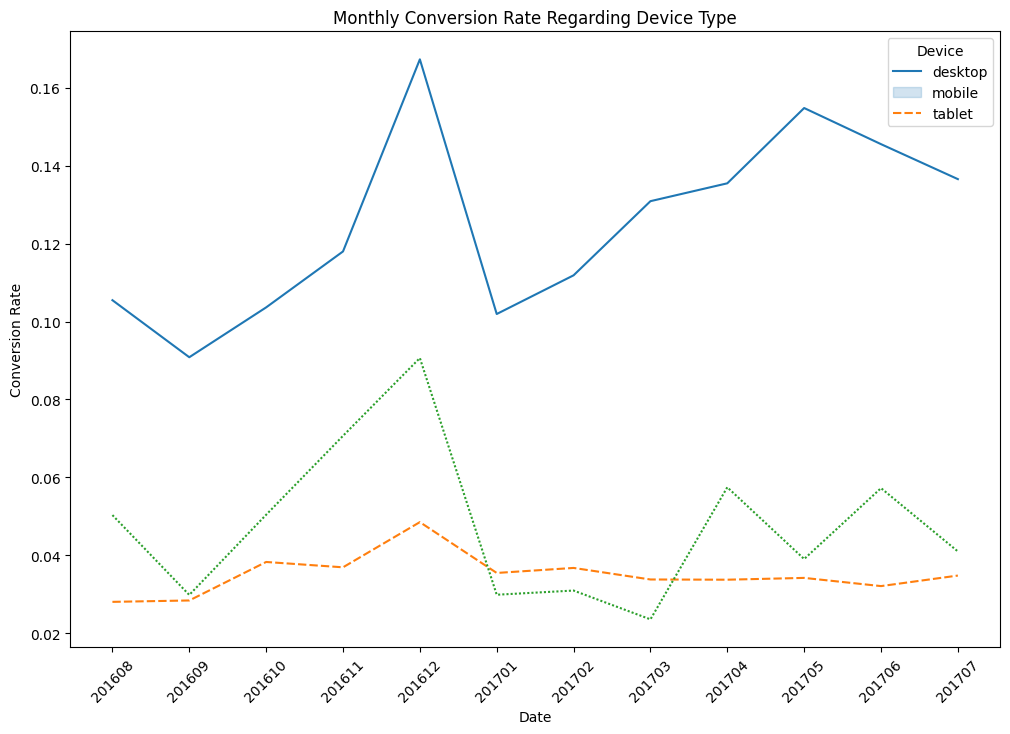

In [ ]:
# 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=conversion_rates_df)
plt.title('Monthly Conversion Rate Regarding Device Type')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Device', labels=conversion_rates_df.columns)
plt.show()


1611에 모든 device의 전환율이 증가했다가 1612 ~ 1701에 폭락함 . 

연말/연초 기념 세일을 했나? 블랙프라이데이? 유료 광고를 집행했나? 아니면 ui/ux가 바뀌었나? 근데 세일을 했다기에는 1609부터 꾸준한 증가가 있었음 

In [ ]:
# 결제 -> 구매 완료 단계로 넘어가는 것도 확인해보자 원래 이렇게 낮은지 

filtered_data = device_monthly_conv[device_monthly_conv['action'].isin(['결제', '구매 완료'])]
pivot_table = filtered_data.pivot_table(index='YearMonth', columns=['Device', 'action'], values='users', aggfunc='sum')

conversion_rates = {}
for device in pivot_table.columns.levels[0]:
    conversion_rates[device] = pivot_table[(device, '구매 완료')] / pivot_table[(device, '결제')]

conversion_rates_df2 = pd.DataFrame(conversion_rates, index=pivot_table.index)

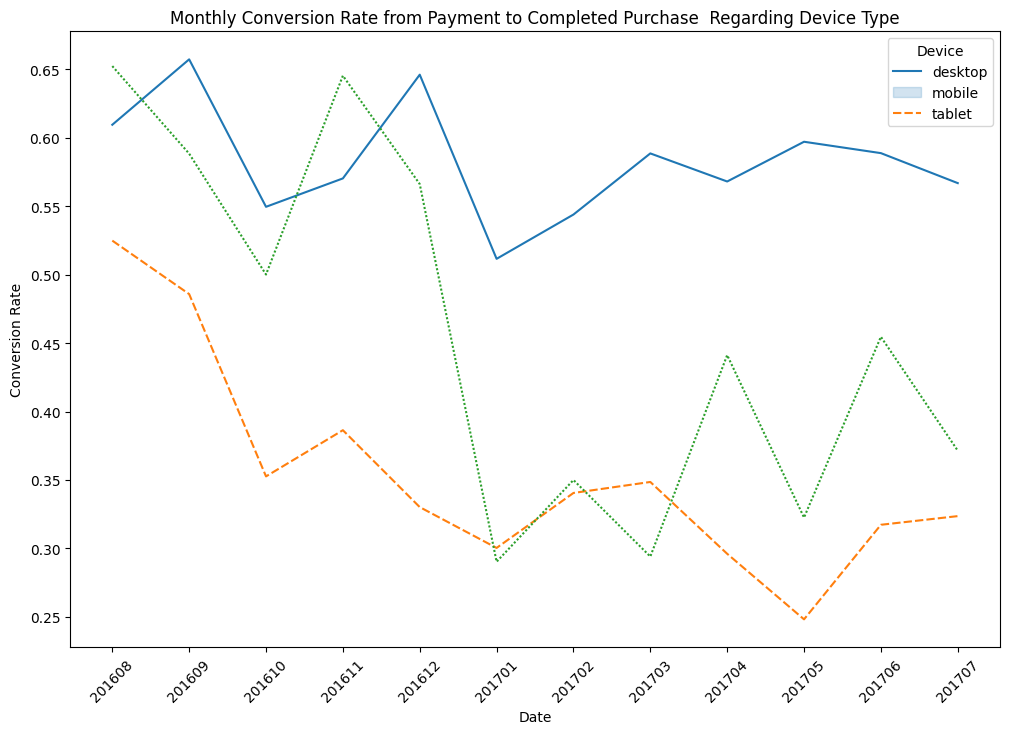

In [ ]:
# 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=conversion_rates_df2)
plt.title('Monthly Conversion Rate from Payment to Completed Purchase  Regarding Device Type')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Device', labels=conversion_rates_df.columns)
plt.show()

이때 결제창 ui/ux에 변화가 있었나? 아니면 결제 로딩 시간이 오래 걸렸나? 

특히 mobile의 결제창 - 구매 완료 전환률은 1612 ~ 1701을 기준으로 거의 반토막이 났다.

desktop의 범위는 0.5 ~ 0.65 사이를 원래 왔다 갔다 하는 것 같음 


In [ ]:
query = """
SELECT hits.type
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
GROUP BY hits.type
"""

conv = client.query(query).result().to_dataframe()

conv

,type
0,EVENT
1,PAGE


In [ ]:
# device별 결제 로딩 시간을 구해보자
# hits.latencyTracking.pageLoadTime 사용 

query = """
SELECT
  device.deviceCategory AS Device,
  FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
  AVG(hits.latencyTracking.pageLoadTime) AS AvgPageLoadTime,
  CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  hits.eCommerceAction.action_type IN ('5', '6') AND
  hits.latencyTracking.pageLoadTime IS NOT NULL
GROUP BY
  Device,
  YearMonth,
  action
ORDER BY
  YearMonth, Device
"""

device_time_conv = client.query(query).result().to_dataframe()

merged_df = device_time_conv.pivot_table(index=['YearMonth', 'Device'], columns='action', values='AvgPageLoadTime').reset_index()

merged_df['LoadTimeDifference'] = merged_df['구매 완료'] - merged_df['결제']


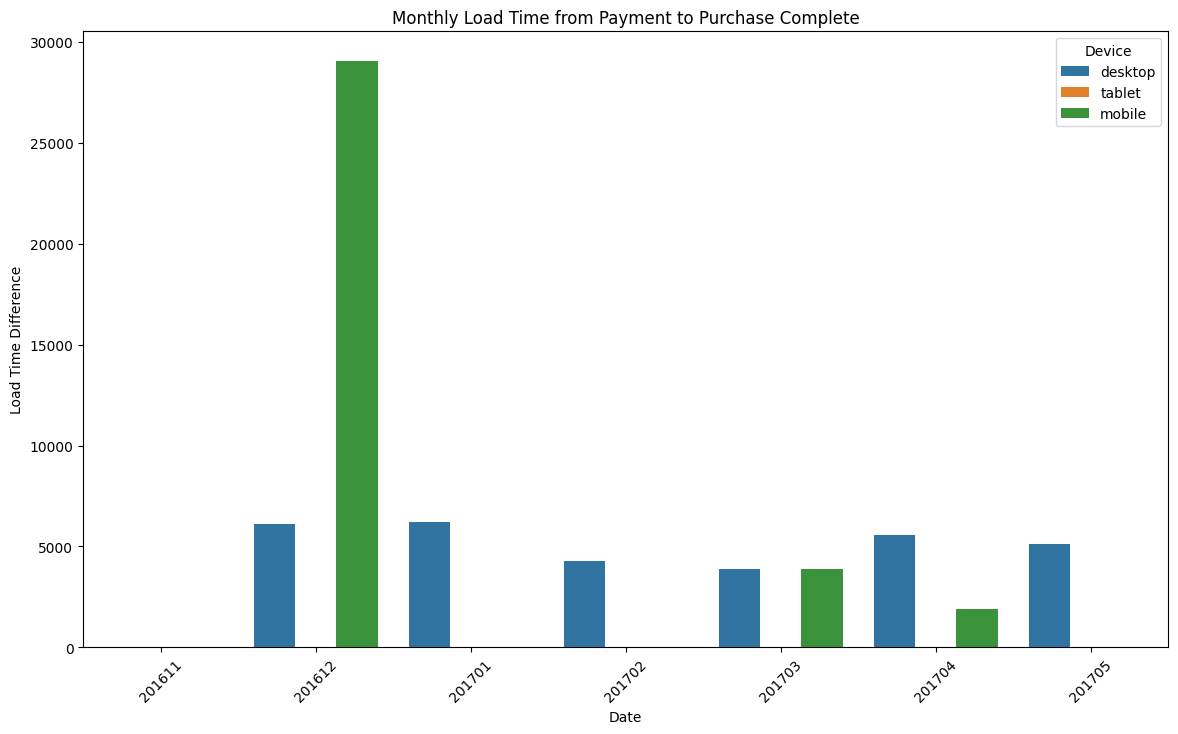

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(data=merged_df, x='YearMonth', y='LoadTimeDifference', hue='Device')
plt.title('Monthly Load Time from Payment to Purchase Complete')
plt.xlabel('Date')
plt.ylabel('Load Time Difference')
plt.xticks(rotation=45)
plt.legend(title='Device')
plt.show()

몇몇 단계/기기에선 데이터의 부재로 확인할 수 없었지만, 

201612 ~ 201701의 경우 mobile 유저의 경우 결제 ~ 구매 완료 과정에서 다른 때보다 6배 오래 걸렸음을 확인할 수 있음. 왜 오래 걸렸지? 서버 문제?

이때문에 결제 -> 구매 완료 전환률이 폭락한 게 아닐까 싶음.

#### 9) 결제 시간대별 코호트 분석

In [ ]:
# 변수 hits.hour 사용

query = """
SELECT
  FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
  hits.hour AS Hour,
  CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
  COUNT(DISTINCT fullVisitorID) AS users    
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  hits.eCommerceAction.action_type IN ('1', '6')
GROUP BY
  YearMonth, Hour, action
ORDER BY
  YearMonth, Hour
"""

time_conv = client.query(query).result().to_dataframe()

KeyboardInterrupt: 

In [ ]:
# '제품 목록'과 '구매 완료'로 분리된 데이터를 YearMonth와 Hour를 기준으로 병합합니다.
pivot_df = time_conv.pivot_table(index=['YearMonth', 'Hour'], columns='action', values='users', aggfunc='sum').reset_index()

# '제품 목록 대비 구매 완료' 비율을 계산합니다.
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 월별, 시간대별 전환율을 시각화하기 위한 피벗 테이블 생성
pivot_table = pivot_df.pivot("Hour", "YearMonth", "ConversionRate")
pivot_table.drop(columns='201708', inplace = True)

C:\Users\USER\AppData\Local\Temp\ipykernel_26856\2124412632.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



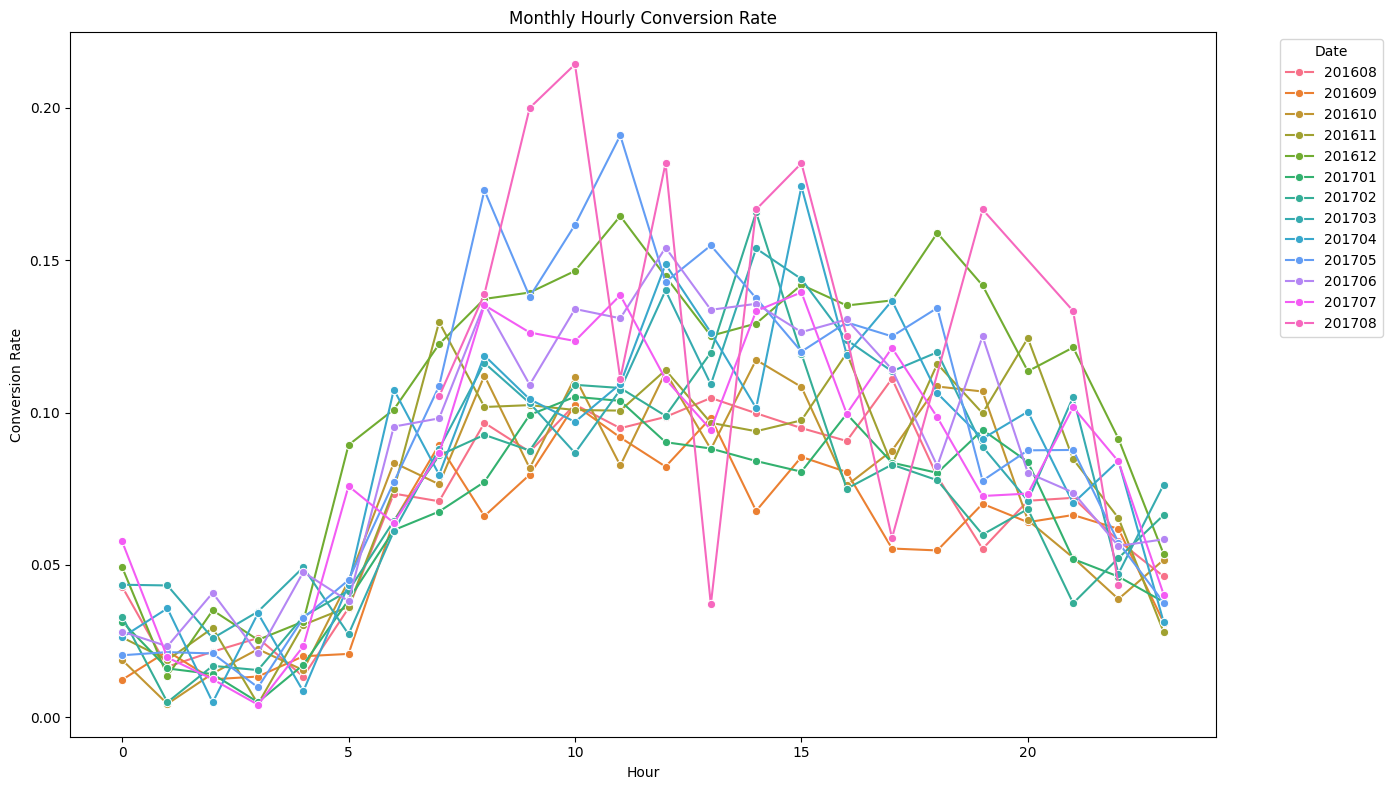

In [ ]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='Hour', y='ConversionRate', hue='YearMonth', marker='o')
plt.title('Monthly Hourly Conversion Rate')
plt.ylabel('Conversion Rate')
plt.xlabel('Hour')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### 대륙 코호트

In [ ]:
# 변수 hits.hour 사용

query = """
SELECT 
    geoNetwork.continent AS Continent,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
    AND _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY 
    Continent,
    YearMonth,
    action
ORDER BY 
    Continent, YearMonth, action
"""

geo_table = client.query(query).result().to_dataframe()

In [ ]:
# '구매 완료'와 '제품 목록'을 YearMonth와 Continent 별로 집계
purchase_completed = geo_table[geo_table['action'] == '구매 완료'].groupby(['YearMonth', 'Continent'])['users'].sum().reset_index(name='구매 완료')
product_listed = geo_table[geo_table['action'] == '제품 목록'].groupby(['YearMonth', 'Continent'])['users'].sum().reset_index(name='제품 목록')

# 데이터 병합
merged_df = pd.merge(product_listed, purchase_completed, on=['YearMonth', 'Continent'])

# 전환율 계산
merged_df['conversion_rate'] = merged_df['구매 완료'] / merged_df['제품 목록']

# 대륙별 전환율 계산 (여기서는 예제 데이터가 모두 Africa이므로 하나의 값만 나옴)
continent_conversion_rate = merged_df.groupby('Continent')['conversion_rate'].mean().reset_index()


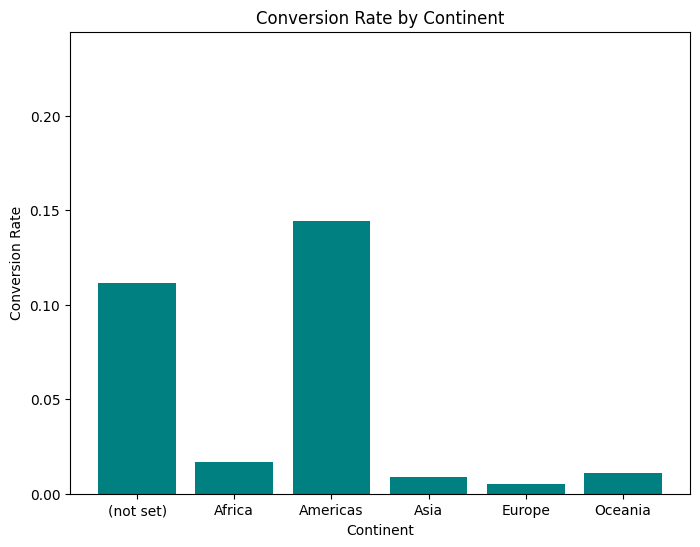

In [ ]:
# 시각화
plt.figure(figsize=(8, 6))
plt.bar(continent_conversion_rate['Continent'], continent_conversion_rate['conversion_rate'], color='teal')
plt.title('Conversion Rate by Continent')
plt.xlabel('Continent')
plt.ylabel('Conversion Rate')
plt.ylim(0, max(continent_conversion_rate['conversion_rate']) + 0.1)  # 전환율 최대값보다 약간 더 높게 설정
plt.show()
